# Notebook de nettoyage
## Adrian Rodriguez
## Projet 4 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [1]:
import pandas as pd
pd.options.display.max_columns = None

import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter

from bs4 import BeautifulSoup
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import PIL.Image
import en_core_web_sm

pd.options.display.max_columns = None
plt.style.use("default")
nlp = en_core_web_sm.load()

from functions import *

---
# 1. Importation et exploration préliminaire
Les données ont été extraite du site stackexchangeexplorer. J'ai traité des post récents.    
Requête SQL : 
```     
DECLARE @max_date as DATETIME = DATEADD(MONTH, -1, GETDATE())

SELECT Id, Title, Body, Tags    
FROM posts
WHERE CreationDate < @max_date AND PostTypeId = 1 AND Score > 19
ORDER BY CreationDate DESC
```

Les données ont été stockées dans le fichiser 'QueryResults.csv'.

In [2]:
questions_raw = pd.read_csv('src/Questions50K_QueryResults.csv')

In [3]:
questions_raw.head()

,Id,Title,Body,Tags
0,63087217,Changes using mutable reference of a field are...,<p>I was trying to manipulate the field <code>...,<rust><reference><move>
1,63078532,Is it possible to create a new data type in Ja...,<p>Is it possible to create a new data type in...,<javascript>
2,63067062,Elastic Search indexes gets deleted frequently,<p>I'm running an elastic search for a persona...,<elasticsearch>
3,63046397,Why does this usage of C++17 if constexpr fail?,<p>I am trying to use C++17 <code>if constexpr...,<c++><if-statement><templates><c++17><constexpr>
4,63043585,"VSCode showing ""Java 11 or more recent is requ...",<p>VSCode started showing me today a pop-up sa...,<java><visual-studio-code>


In [4]:
questions_raw.shape

(50000, 4)

In [5]:
questions_raw.columns

Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')

In [6]:
questions_raw.isna().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [7]:
questions = questions_raw.copy()

# 2. Exploration des tags associés aux questions
Je cherche à connaître quels sont les tags les plus utilisés et à savoir

In [8]:
questions.Tags = questions.Tags.apply(lambda x: x.replace('<', '').replace('>', ' ')).str.split()
tags = questions.Tags.explode().reset_index()
tags = tags.groupby('Tags').count().sort_values(by='index', ascending=False).reset_index().rename(columns={'index': 'recurrence'})
print(f'Nous avons {len(tags)} tags utilisés sur la période')

Nous avons 10573 tags utilisés sur la période


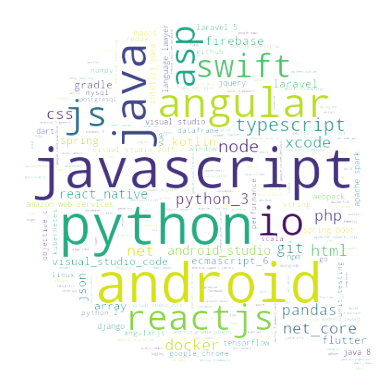

In [9]:
tags.Tags = tags.Tags.str.replace('-', '_')
text = (tags.Tags + ' ') * tags['recurrence']
text = ''.join(text)

# Création de l'objet
mask = np.array(PIL.Image.open('src/bulle.jpg'))
wordcloud = WordCloud(width=1200, height=780, background_color="rgba(255, 255, 255, 0)", mode="RGBA", collocations=False, mask=mask).generate(text)
 
# Génération de l'image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

plt.savefig('img/img_wordcloud_tags.png',
            transparent=True,
            bbox_inches="tight")

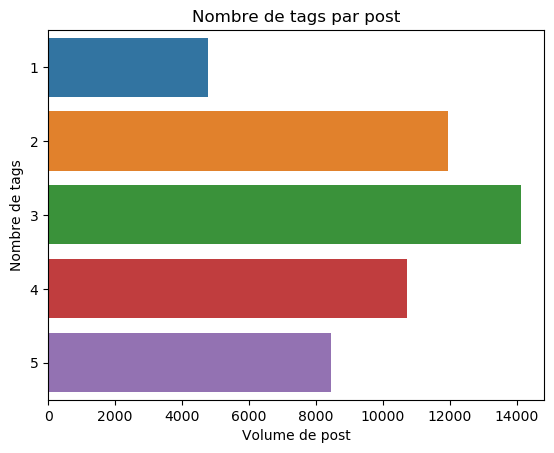

In [10]:
tags_count = questions.Tags.apply(lambda x: len(x)).reset_index()
tags_count = tags_count.groupby('Tags').count().reset_index()

plt.clf()
sns.barplot(y='Tags',
            x='index',
            data=tags_count,
            orient='h')
plt.title('Nombre de tags par post')
plt.xlabel('Volume de post')
plt.ylabel('Nombre de tags')

plt.savefig('img/img_tags_count.png',
            transparent=True,
            bbox_inches="tight")

100 % du volume des tags sont représenté par 10572 tags soit une proportion de 100.0 % de la population des tags


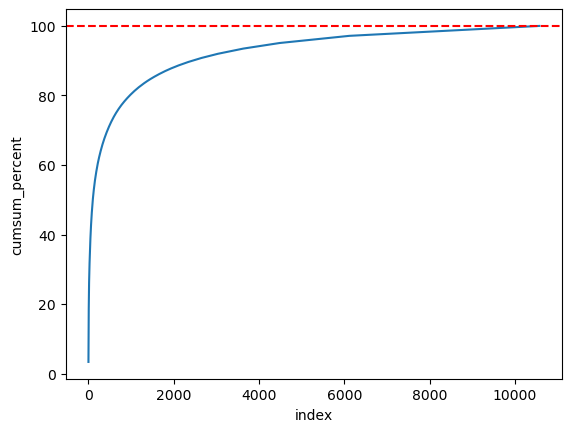

In [29]:
tags_imp = (tags['recurrence'].cumsum() / tags['recurrence'].sum()) * 100
tags_imp = tags_imp.reset_index().rename(columns={'recurrence': 'cumsum_percent'})

vol_treshold = 100
qty_tags = len(tags_imp[tags_imp.cumsum_percent < vol_treshold])
vol_qty_tags = round(qty_tags / len(tags_imp) * 100, 0)
print(f'{vol_treshold} % du volume des tags sont représenté par {qty_tags} tags soit une proportion de {vol_qty_tags} % de la population des tags')

sns.lineplot(x='index', y='cumsum_percent', data=tags_imp)
plt.axhline(y=vol_treshold, color='red', linestyle='--')
plt.show()

In [46]:
bag_tags = tags
bag_tags.tail(10)

,Tags,recurrence
10563,joomla3.0,1
10564,job_queue,1
10565,jnlp,1
10566,jndi,1
10567,jmxtrans,1
10568,jms_topic,1
10569,jms,1
10570,jmod,1
10571,jmockit,1
10572,zurb_foundation_6,1


In [47]:
bag_tags = bag_tags.Tags.to_list()

Les tags les moins souvent utilisés l'ont été au moins 20 fois sur des sujets reconnus et pertinents

# 4. NLP Preprocessing

In [48]:
# Je limite le nombre d'observation pour la phase de dev
questions = questions.head(10000)

## Nettoyage et lemmatisation

En procédant à un test maison, je me rends facilement compte que je peux mettre des informations importante soit dans le titre, soit dans le body. Je ne pense pas forcément à les mettre dans les 2 blocs. De ce fait, je dois analyser le champs `Body` et le champs `Title`.

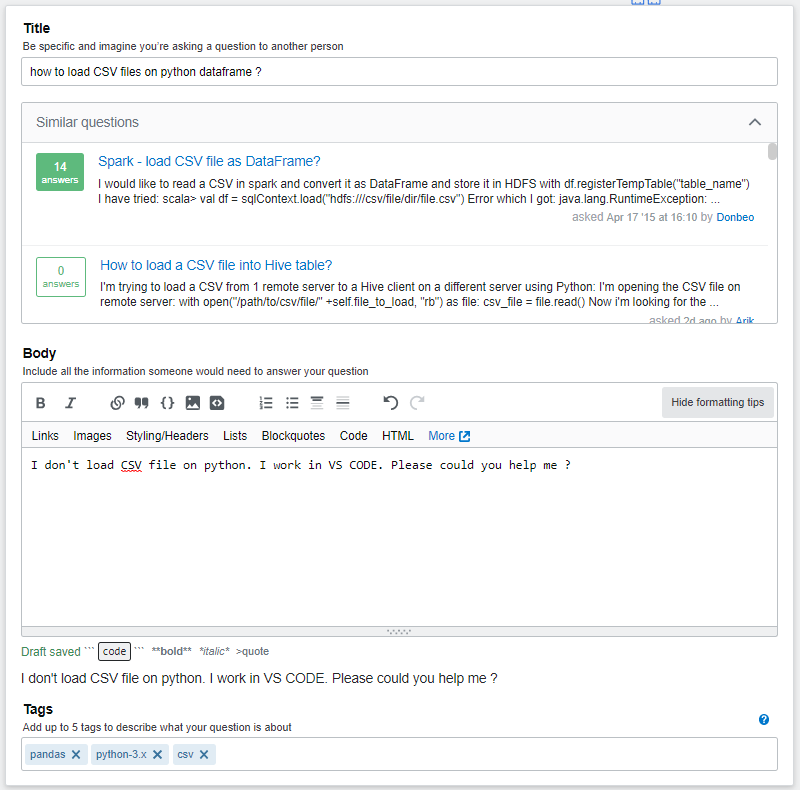

In [49]:
Image('src/post.png')

In [50]:
questions['Title_Body'] = questions.Title + ' ' + questions.Body
questions

,Id,Title,Body,Tags,Title_Body
0,63087217,Changes using mutable reference of a field are...,<p>I was trying to manipulate the field <code>...,"[rust, reference, move]",Changes using mutable reference of a field are...
1,63078532,Is it possible to create a new data type in Ja...,<p>Is it possible to create a new data type in...,[javascript],Is it possible to create a new data type in Ja...
2,63067062,Elastic Search indexes gets deleted frequently,<p>I'm running an elastic search for a persona...,[elasticsearch],Elastic Search indexes gets deleted frequently...
3,63046397,Why does this usage of C++17 if constexpr fail?,<p>I am trying to use C++17 <code>if constexpr...,"[c++, if-statement, templates, c++17, constexpr]",Why does this usage of C++17 if constexpr fail...
4,63043585,"VSCode showing ""Java 11 or more recent is requ...",<p>VSCode started showing me today a pop-up sa...,"[java, visual-studio-code]","VSCode showing ""Java 11 or more recent is requ..."
...,...,...,...,...,...
9995,46469076,How to Send Kubernetes Logs to AWS CloudWatch?,<h1>AWS CloudWatch Logs in Docker</h1>\n\n<p>S...,"[amazon-web-services, docker, kubernetes, amaz...",How to Send Kubernetes Logs to AWS CloudWatch?...
9996,46468220,How can I delete derived data in Xcode 9?,<p>I have installed Xcode 9 today morning. It ...,"[xcode, xcode9]",How can I delete derived data in Xcode 9? <p>I...
9997,46467561,Difference between google() and maven { url 'h...,<p>Is there any difference between google() an...,"[java, android, gradle, android-gradle-plugin]",Difference between google() and maven { url 'h...
9998,46467407,Does this function have explicit return values...,"<p>I have a <a href=""https://en.wikipedia.org/...","[c++, templates, return, code-coverage]",Does this function have explicit return values...


Lorsque j'analyse une question. Je constate qu'il peut y avoir des blocs de codes, et des blocs d'image. Ces blocs génèrent du bruit et n'apporte pas de ou très peu de valeurs ajouté au sens de la question. Je décide de les retirer. Les blocs de code non préformaté ne peuvent pas être retiré  
Je retire également les tags HTML, les retours ligne \n, les éventuels caractères accentués et je passe tous les caractères en minuscule s'il ne le sont pas déjà.

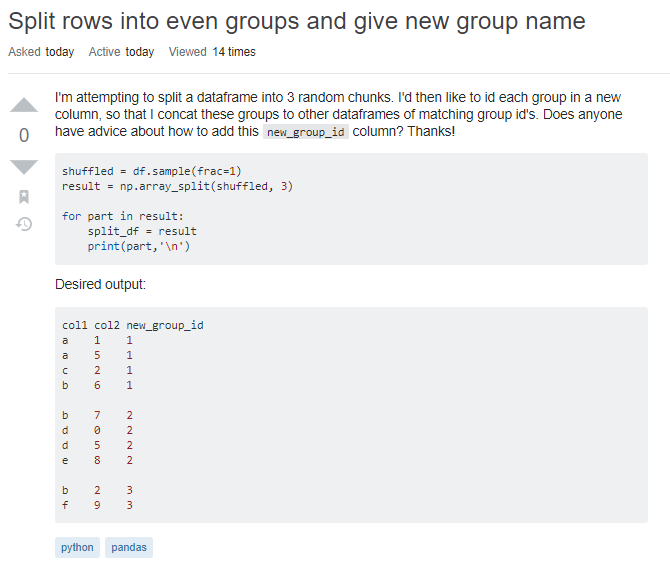

In [51]:
Image('src/question.png')

In [52]:
# Je retire les bloc de code préformatté et les bloc image
questions.Title_Body = questions.Title_Body.apply(lambda x: extract_preformattext_imageurl(x))
# Je retire les tags HTML
questions.Title_Body = questions.Title_Body.apply(lambda x: strip_html_tags(x))
# Je retire les retours ligne \n
questions.Title_Body = questions.Title_Body.apply(lambda x: x.replace('\n', ''))
# Je retire les éventuels caractères accentués
questions.Title_Body = questions.Title_Body.apply(lambda x: remove_accented_chars(x))
# Je passe tous les caractères en minuscule
questions.Title_Body = questions.Title_Body.apply(lambda x: x.lower())

questions.Title_Body.head(20)

0     changes using mutable reference of a field are...
1     is it possible to create a new data type in ja...
2     elastic search indexes gets deleted frequently...
3     why does this usage of c++17 if constexpr fail...
4     vscode showing "java 11 or more recent is requ...
5     why is __int128_t faster than long long on x86...
6     discord.py glitch or random error: typeerror: ...
7     bigint inconsistencies in powershell and c#  a...
8     how does implicit conversion work in java?  i ...
9     chrome 84 inspect element, find results not hi...
10    how can i prevent chrome from blocking a xlsx ...
11    is there any need to switch to modules when mi...
12    what is a niebloid?  with c++20 we can read th...
13    disable chrome v 84 issues tab in js console  ...
14    why does equality not appear to be a symmetric...
15    why does modifying a field that is referenced ...
16    react dev tools - deactivate "break on warning...
17    what is the most efficient way to fill mis

In [53]:
questions['Lemma_Title_Body'] = questions.Title_Body.apply(lambda x: remove_stopwords_PRON(x, nlp, bag_tags))
questions.Lemma_Title_Body

0       change use mutable reference field reflect ori...
1       possible create new data type javascript possi...
2       elastic search index delete frequently run ela...
3       usage c++17 constexpr fail try use c++17 const...
4       vscode java recent require run download instal...
                              ...                        
9995    send kubernete log aws cloudwatch aws cloudwat...
9996    delete derive datum xcode instal xcode today m...
9997    difference google maven url difference google ...
9998    function explicit return value control path ce...
9999    warning character deprecate use string substre...
Name: Lemma_Title_Body, Length: 10000, dtype: object

In [54]:
tokens = token_text(' '.join(questions.Lemma_Title_Body), nlp)
Counter(tokens).most_common(10)

ValueError: [E088] Text of length 3218408 exceeds maximum of 1000000. The v2.x parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.

In [55]:
def remove_verbs_adj(text, model=nlp, protect=[]):
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    txt = [token.text for token in doc
           if token.text in protect]

    txt = ' '.join(txt)
    return txt

In [56]:
questions['Lemma_Title_Body'] = questions.Lemma_Title_Body.apply(lambda x: remove_verbs_adj(x, nlp, bag_tags))
questions['Lemma_Title_Body']

0       mutable reference field instance field struct ...
1             javascript javascript string declare output
2               search search project cloud search figure
3       c++17 constexpr c++17 constexpr conditional co...
4       java require download apache version point wor...
                              ...                        
9995    docker set driver docker driver pod docker dep...
9996                                          xcode xcode
9997    difference maven url difference maven url buil...
9998    function explicit return path encode review ex...
9999    character string instance string substring str...
Name: Lemma_Title_Body, Length: 10000, dtype: object

## Réduction de dimension

## Vectorisation

In [57]:
X_train, X_test, y_train, y_test = train_test_split(questions.Lemma_Title_Body, questions.Tags, test_size=0.2, random_state=123)

In [58]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [59]:
vectorizer = CountVectorizer()
# Generate training Bow vectors
X_train_bow = vectorizer.fit_transform(X_train)
# Generate test BoW vectors
X_test_bow = vectorizer.transform(X_test)

print(f'Dimension X_train_bow : {X_train_bow.shape}')
print(f'Dimension X_test_bow : {X_test_bow.shape}')

print(f'Le vecteur bag of word contient {X_train_bow.shape[1]} mots')

Dimension X_train_bow : (8000, 2914)
Dimension X_test_bow : (2000, 2914)
Le vecteur bag of word contient 2914 mots


## Classification multilabel

In [60]:
mlb = MultiLabelBinarizer()
# Reprise des tags originaux et test de inverse_transform
y_test = mlb.fit_transform(y_test)
y_test_inversed = mlb.inverse_transform(y_test)

# Mise en place la classification supervisée multilabel
y_train = mlb.fit_transform(y_train)

In [61]:
classifier = [('LogisticRegression', LogisticRegression(C=1, penalty='l1', dual=False, solver='liblinear')),
              ('LinearSVC', LinearSVC(C=1, penalty='l1', dual=False, loss='squared_hinge')), 
              ('MultinomialNB', MultinomialNB(alpha=1.0))]

for clf_name, clf in classifier:
    print(f'Classification avec {clf_name}...\n')
    
    model = OneVsRestClassifier(clf)
    if clf_name == 'LinearDiscriminantAnalysis':
        model.fit(np.array(X_train_bow), y_train)
    else: 
        model.fit(X_train_bow, y_train)

    y_pred = model.predict(X_test_bow)

    y_pred_inversed = mlb.inverse_transform(y_pred)

    # Comparaison des résultats
    for i in range(5):
        print(f'{X_test[i]}\n\nTags originaux: {y_test_inversed[i]}\nTags prédits: {y_pred_inversed[i]}\n\n')
    
    print('##################################################\n\n')

Classification avec LogisticRegression...

public constructor optional java optional public constructor

Tags originaux: ('constructor', 'java', 'java-8', 'optional')
Tags prédits: ('java',)


difference precision difference precision r turn r stat sqrt modifier difference precision

Tags originaux: ('floating-point', 'precision', 'r', 'rounding')
Tags prédits: ('c#',)


command package.json server server command auto command webpack npm terminal webpack server gulp

Tags originaux: ('node.js', 'package.json')
Tags prédits: ('npm', 'webpack')


render render refresh layout restart android antivirus android android sdk android sdk platform android q android sdk platform default openjdk platform binary android project replace layout layout

Tags originaux: ('android', 'android-studio', 'layout', 'render')
Tags prédits: ('android', 'android-sdk-tools', 'android-studio')


break safari expression javascript regex safari expression

Tags originaux: ('javascript', 'regex', 'safari')
Tags pré